# BDSA 603 - Big Data Analytics
# Practice 2 - Analytics on UK Smart Meter Data

* ### Supervised By: Dr. Hesham Al-Ammal
* ### Coded By: Ahmed Khedr
* ### UOB ID: 20113798

## Introduction
Energy plays an important role in every aspect of today’s world. 
With the ever-increasing demand for energy, comes the importance of understanding how it is being consumed to allow governments to reduce carbon emissions, efficiently use and conserve energy, and plan for reliable energy sources.
***
## Research Problem
This research & implemented analysis aims to:
1. Explore relationship between Weather Conditions and Energy Consumption <b><a style='color:red' href='#Task-1:'>Jump to Section</a></b>
2. Explore relationship between UK Holidays and Energy Consumption <b><a style='color:red' href='#Task-2:'>Jump to Section</a></b>
3. Explore (& visualize) the relationship between ACORN household categorization and energy consumption over a year <b><a style='color:red' href='#Task-3:'>Jump to Section</a></b>
***
## Research Scope
* The United Kingdom
* Energy readings from November 2011 until February 2014 (subject to data cleansing)
* Weather conditions that will be considered in this research will be **temperature only**
***
## Data Sources
* UK Power Networks (https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)
* Smart Meters in London (https://www.kaggle.com/jeanmidev/smart-meters-in-london)

## Replication Steps (Important)
To be able to replicate this notebook (in any step) you must implement all the cells starting under "Data Collection & Preparation" as they load the basic (simple) and crucial datasets used across all tasks.

After that, you can implement any task you wish.
***
***

# Data Collection & Preparation
In this section, we will:
* Clean up the datasets
* Combine and prepare the dataset
* Investigate inconsistency and missing values

In [1]:
import os # Operating System
import datetime # DateTime
import numpy as np # NumPy
import pandas as pd # Pandas
import seaborn as sns # Seaborn
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt # Mat-Plot Lib

Wall time: 3.62 s


In [12]:
# Import Map Reduce and Dask
from MR_SumEC_ByHousehold_ByDate import MR_SumEC_ByHousehold_ByDate # MR - Task 1
import dask # Dask
from dask.distributed import Client # Dask Distributed
import dask.dataframe as ddf # Dask Dataframe Implementation

In [13]:
%%time
# Create Dask Client
daskClient = Client(threads_per_worker=4,n_workers=2,memory_limit='2GB')
daskClient

Wall time: 1.66 s


Client Scheduler: tcp://127.0.0.1:53547 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 8 Memory: 4.00 GB


# Global Variables 
Including Research Scoping

In [2]:
# Define Study Time Frame (Years) - as defined by research
StudyTimeFrame_StartYear = 2011
StudyTimeFrame_EndYear = 2014

# Datetime Format
datetimeFormat = '%Y-%m-%d'

# Dataset directory
Dataset_Directory = 'dataset/'
CleanedDataset_Directory = 'dataset_clean/'

# Load and Clean Up Simple Datasets

### Load & Clean UK Holidays

In [3]:
%%time
df_UKHolidays = pd.read_csv(f"{Dataset_Directory}uk_bank_holidays.csv")
# df_UKHolidays.info()

# Rename columns to be read-able
df_UKHolidays.columns = ['Date', 'Name']

# Convert 'Date' to DateTime data type
df_UKHolidays['Date'] = pd.to_datetime(df_UKHolidays['Date'])

# Create Date Only Attribute
df_UKHolidays['DateOnly'] = df_UKHolidays['Date'].dt.strftime(datetimeFormat)

# Drop duplicates by Date
df_UKHolidays = df_UKHolidays.drop_duplicates(subset=['Date'])

# Remove null data
df_UKHolidays.dropna()

# Sort by Date
df_UKHolidays = df_UKHolidays.sort_values(by='Date')

# Ensure no null values exist in all columns 
#assert df_UKHolidays.isnull().sum().sum() == 0

Wall time: 80.1 ms


Wall time: 144 ms


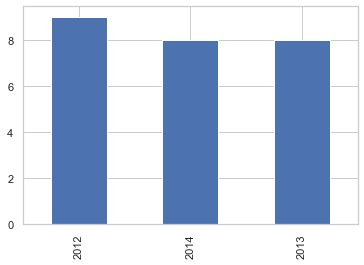

In [4]:
%%time
Count_UKHolidays_ByYear = df_UKHolidays["Date"].dt.year.value_counts()
Count_UKHolidays_ByYear.plot.bar() # We can see that we do not have holidays for 2011

# Update Study Time Frame
StudyTimeFrame_StartYear = min(df_UKHolidays["Date"].dt.year)
StudyTimeFrame_EndYear = max(df_UKHolidays["Date"].dt.year)

### Load & Clean ACORN Categories

In [5]:
%%time
df_ACORN = pd.read_csv(f"{Dataset_Directory}acorn_categories.csv")
#df_ACORN.info()

# Rename columns to be read-able
df_ACORN.columns = ['Code', 'Name', 'Group_Name', 'Color']

# Select only relevent columns
df_ACORN = df_ACORN[['Code', 'Name', 'Color']]

# Drop duplicates
df_ACORN = df_ACORN.drop_duplicates()

# Remove null data
df_ACORN.dropna()

# Ensure no null values exist in all columns 
assert df_ACORN.isnull().sum().sum() == 0

Wall time: 15.4 ms


### Load & Clean Households

In [6]:
%%time
df_Households = pd.read_csv(f"{Dataset_Directory}informations_households.csv")
#df_Households.info()

# Select only relevent columns
df_Households = df_Households[['LCLid', 'Acorn']]

# Rename columns to be read-able
df_Households.columns = ['ID', 'ACORN_Category']

# Apply striping of "ACORN-" from category code
df_Households['ACORN_Category'] = df_Households['ACORN_Category'].apply(lambda x: x.upper().replace('ACORN-','').strip())

df_Households_invalid = pd.DataFrame() 
# Remove Empty ACORN categories
df_Households_invalid = df_Households_invalid.append(df_Households[df_Households['ACORN_Category']==""])
df_Households = df_Households[df_Households['ACORN_Category']!=""]

# Remove invalid ACORN categories
df_Households_invalid = df_Households_invalid.append(df_Households[~df_Households['ACORN_Category'].isin(df_ACORN['Code'])])
df_Households = df_Households[df_Households['ACORN_Category'].isin(df_ACORN['Code'])]

# Create new attribute for ACORN code
df_Households['ACORN_Code'] = df_Households['ACORN_Category']
# Replace ACORN category code with category name (to group data by ACORN categery rather ACORN group)
df_Households['ACORN_Category'] = df_Households['ACORN_Category'].map(df_ACORN.set_index('Code')['Name'])

# Drop duplicates by ID
df_Households = df_Households.drop_duplicates(subset=['ID'])

# Remove null data
df_Households.dropna()

# Ensure no null values exist in all columns 
assert df_Households.isnull().sum().sum() == 0

Wall time: 57 ms


Wall time: 65 ms


<AxesSubplot:>

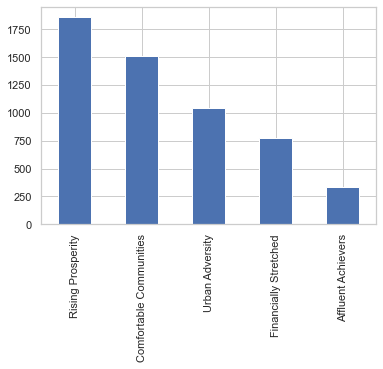

In [7]:
%%time
Count_Households_ByACORNCategory = df_Households["ACORN_Category"].value_counts()
Count_Households_ByACORNCategory.plot.bar() # Visualization to see distribution of houses on ACORN categories

### Load & Clean Weather Data

In [8]:
%%time
df_Weather = pd.read_csv(f"{Dataset_Directory}weather_daily_darksky.csv")
#df_Weather.info()

# Select only relevent columns
df_Weather = df_Weather[['time', 'temperatureMax', 'temperatureMin']]

# Rename columns to be read-able
df_Weather.columns = ['Date', 'Temp_Max', 'Temp_Min']

# Convert 'Date' to DateTime data type
df_Weather['Date'] = pd.to_datetime(df_Weather['Date'])

# Drop duplicates by Date
df_Weather = df_Weather.drop_duplicates(subset=['Date'])

# Create Date Only Attribute
df_Weather['DateOnly'] = df_Weather['Date'].dt.strftime(datetimeFormat)

# Remove null data
df_Weather.dropna()

# Calculate the Average Temperature for each day
df_Weather['Temp_Avg'] = np.mean([df_Weather['Temp_Max'], df_Weather['Temp_Min']], axis=0)

# Sort by Date
df_Weather = df_Weather.sort_values(by='Date')

# Ensure no null values exist in all columns 
assert df_Weather.isnull().sum().sum() == 0

Wall time: 123 ms


Wall time: 54.6 ms


<AxesSubplot:>

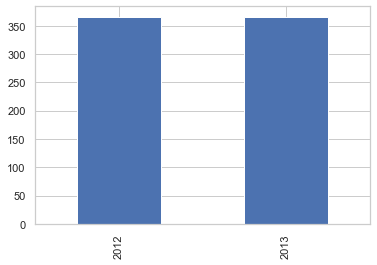

In [9]:
%%time
# Verify Weather Data Availability
Count_WeatherData_ByYear = df_Weather["Date"].dt.year.value_counts()
Count_WeatherData_ByYear.plot.bar() # We can see that we do not have enough data for 2011 and 2014

# Update Study Time Frame (years that have full daily weather records)
StudyTimeFrame_StartYear = min(Count_WeatherData_ByYear[Count_WeatherData_ByYear >= 365].index)
StudyTimeFrame_EndYear = max(Count_WeatherData_ByYear[Count_WeatherData_ByYear >= 365].index)

# Remove excluded data
df_Weather = df_Weather[(StudyTimeFrame_StartYear <= df_Weather['Date'].dt.year) &
                        (df_Weather['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Verify Weather Data Availability
Count_WeatherData_ByYear = df_Weather["Date"].dt.year.value_counts()
Count_WeatherData_ByYear.plot.bar() # We can see that we do not have enough data for 2011 and 2014

Wall time: 86.1 ms


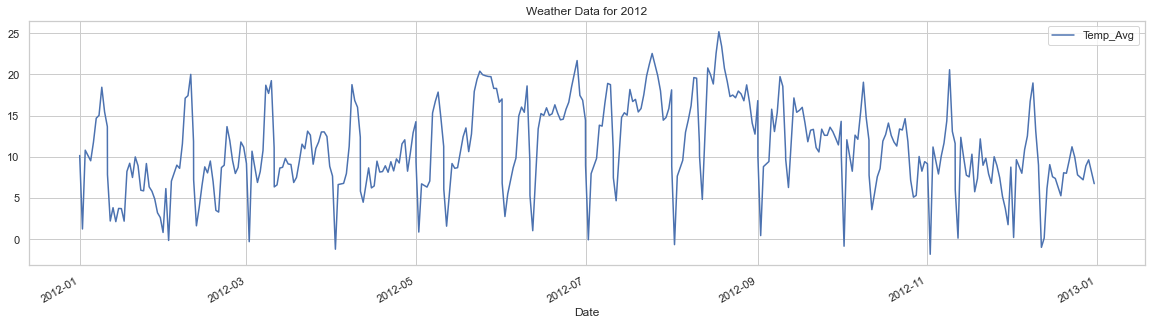

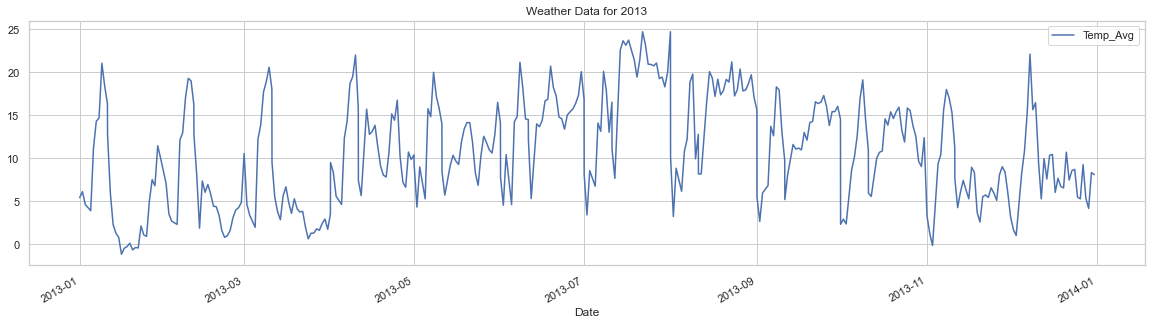

In [10]:
%%time
# Visualize Weather Data for each Year (Daily Visualization)
df_Weather_GroupedByYear = df_Weather.groupby(df_Weather['Date'].dt.year)
for SingleGroupedYear in dict(list(df_Weather_GroupedByYear)):
    df_SingleGroupedYear = df_Weather_GroupedByYear.get_group(SingleGroupedYear)    
    df_SingleGroupedYear.plot(x='Date', y='Temp_Avg', title='Weather Data for '+ str(SingleGroupedYear),
                              figsize=(20,5), grid=True, legend = True)

Wall time: 63.3 ms


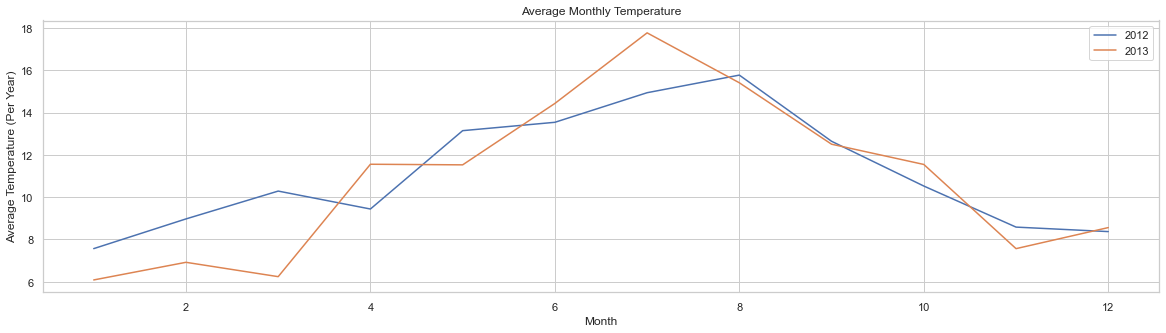

In [11]:
%%time
# Visualize Weather Data for each Year (Monthly Visualization)
plt.figure(figsize=(20,5)) 
df_Weather_GroupedByYear = df_Weather.groupby(df_Weather['Date'].dt.year)
for SingleGroupedYear in dict(list(df_Weather_GroupedByYear)):    
    df_SingleGroupedYear = df_Weather_GroupedByYear.get_group(SingleGroupedYear)    
    df_SingleGroupedYear_ByMonth = df_SingleGroupedYear.groupby(df_SingleGroupedYear['Date'].dt.month)['Temp_Avg'].mean()
    plt.plot(df_SingleGroupedYear_ByMonth)
    plt.title('Average Monthly Temperature')
    plt.xlabel('Month')
    plt.ylabel('Average Temperature (Per Year)')
    plt.legend(dict(list(df_Weather_GroupedByYear)))
    plt.grid(True)

---
# Using Big Data
## We have two main large datasets
1. UK Power Networks (168 files - containing 30 minute interval energy consumption readings)
2. Daily Energy Consumptions Readings (112 files - containing the daily aggregated energy consumptions for all households)

---
# Task 0: Explore which method is best to conduct analysis

### Methods:
1.	Using MapReduce (through MRJob package available through Python)
2.	Using Dask (package available through Python)
3.	Using Dask to execute parallel MapReduce jobs (a blend of the first two methods) 

### To determine which method works best for this task, we will test on two files and compare performance.

##### This below function exposes and allows us to execute the  Map Reduce Job

In [25]:
def Execute_Task1_MRJob(Dataset_Path, Dataset_OutputPath):
    finalargs = Dataset_Path + ["--fYS", str(StudyTimeFrame_StartYear),"--fYE", str(StudyTimeFrame_EndYear)]    
    MRJob_1 = MR_SumEC_ByHousehold_ByDate(args = finalargs)
    with MRJob_1.make_runner() as runner_temp:
        runner_temp.run()
        df_mrjob_response = pd.DataFrame(MRJob_1.parse_output(runner_temp.cat_output()))
        # Reset index to push multi-key as columns
        # df_mrjob_response.reset_index(inplace=True)
        df_mrjob_response.to_csv(Dataset_OutputPath, mode='w', header=False, index=False)
    return Dataset_OutputPath

##### This below function executes the Map Reduce Job Directly by providing the list of Files (no Dask involved)

In [15]:
def Process_Task1_ByDirectMR():
    UKPowerNetworks_DatasetDir = r'dataset/testTask1Input/'
    UKPowerNetworks_OutputDir = r'dataset/testTask1Output/'
    UKPowerNetworks_FileCollection = []
    for ukPowerNetworksFile in os.listdir(UKPowerNetworks_DatasetDir):
        dataset_fullPath = os.path.join(UKPowerNetworks_DatasetDir, ukPowerNetworksFile)
        UKPowerNetworks_FileCollection.append(f'./{dataset_fullPath}')
    dataset_outputPath = os.path.join(UKPowerNetworks_OutputDir, 'v_directmr.csv')    
    return Execute_Task1_MRJob(UKPowerNetworks_FileCollection, dataset_outputPath)

##### This below function executes the Map Reduce Job by leverage parallelization from Dask

In [16]:
def Process_Task1_ByDask():
    UKPowerNetworks_DatasetDir = r'dataset/testTask1Input/'
    UKPowerNetworks_OutputDir = r'dataset/testTask1Output/'
    UKPowerNetworks_CompletedFiles = []
    for ukPowerNetworksFile in os.listdir(UKPowerNetworks_DatasetDir):
        dataset_fullPath = os.path.join(UKPowerNetworks_DatasetDir, ukPowerNetworksFile)
        dataset_outputPath = os.path.join(UKPowerNetworks_OutputDir, ukPowerNetworksFile.replace('Power-Networks-LCL-June2015(withAcornGps)',''))
        locally_completedfile = dask.delayed(Execute_Task1_MRJob)([f'./{dataset_fullPath}'], f'./{dataset_outputPath}')
        UKPowerNetworks_CompletedFiles.append(locally_completedfile)
    return UKPowerNetworks_CompletedFiles

---
---
### Test 1.1 - Testing Task 1 using Direct MR Job (no Dask involved)
The test was conducted using only 2 files for simplification and since it is directly implemented on MRJob, the output is combined into one file (v_directmr.csv)
#### The test took approx. 4:00 - 5:00 minutes (Resulting in 36,543 records)

In [17]:
%%time
print(Process_Task1_ByDirectMR())

No configs specified for inline runner


dataset/testTask1Output/v_directmr.csv
Wall time: 3min 57s


In [18]:
df_test1_1 = ddf.read_csv('dataset/testTask1Output/v_directmr.csv', names=["Key", "Value"], header=None)
df_test1_1.count().compute()

Key      36543
Value    36543
dtype: int64

---
---
### Test 1.2 - Testing Task 1 using Direct MR Job and leveraging parallelization from Dask
The test was conducted using only 2 files for simplification and since each MR job was submitted individually, each will have its own output file.
#### The test took approx. 2:30 - 3 min (Resulting in 36,543 records)

In [19]:
%%time
UKPowerNetworks_CompletedFiles = []
UKPowerNetworks_CompletedFiles = dask.compute(Process_Task1_ByDask())
UKPowerNetworks_CompletedFiles

Wall time: 2min 58s


(['./dataset/testTask1Output/v2_1.csv',
  './dataset/testTask1Output/v2_168.csv'],)

In [20]:
df_test1_2 = ddf.read_csv('dataset/testTask1Output/v2_*.csv', names=["Key", "Value"], header=None)
df_test1_2.count().compute()

Key      36543
Value    36543
dtype: int64

---
---
### Test 1.3 - Testing Task 1 using Dask only
The test was conducted using only 2 files for simplification and since we are using Dask, we can combine both files into one output file (v_dask.csv).
However, since this will not leverage the code written in the MRJob, we will implement the same logic here.
#### The test took approx. 20 seconds (Results in 36,543 records)

In [21]:
%%time
# Load SubSet of Data
df_UKPowerNetworks_FullSet = ddf.read_csv('dataset/testTask1Input/*.csv',
                                          names=['HouseID', 'tariff', 'Date', 'EC', 'AC_Code', 'AC_Name'],
                                          header=0)

# Convert 'Date' to DateTime data type
df_UKPowerNetworks_FullSet['Date'] = ddf.to_datetime(df_UKPowerNetworks_FullSet['Date'])

# Adjust Mid-Night Readings to be for the previous date (last 30-minutes of yesterday)
    ## Declare midnight
midnight = datetime.time(0,0)
    ## Extract midnight records
df_midNightReadings = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time == midnight].compute()
    ## Remove midnight records from dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time != midnight]
    ## Shift midnight to -1 minute
df_midNightReadings['Date'] = (df_midNightReadings['Date'] - datetime.timedelta(minutes = 1))
    ## Re-merge updated records with dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.append(df_midNightReadings)

# Filter out excluded dates (Study Time Frame)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[(StudyTimeFrame_StartYear <= df_UKPowerNetworks_FullSet['Date'].dt.year)
                                                        &
                                                        (df_UKPowerNetworks_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Convert EC readings to numeric (otherwise NaN)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC, errors='coerce'))

# Filter out invalid energy consumption readings
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.dropna(subset=['EC'])

# Create Date Only attribute to allow for group-by function
df_UKPowerNetworks_FullSet['DateOnly'] = df_UKPowerNetworks_FullSet['Date'].dt.strftime(datetimeFormat)
# Group By (Household ID and Date Only)
df_UKPowerNetworks_ByHouse_ByDate = pd.DataFrame(df_UKPowerNetworks_FullSet.groupby(['HouseID', 'DateOnly']).EC.sum().compute())
# Reset index to push multi-key as columns
df_UKPowerNetworks_ByHouse_ByDate.reset_index(inplace=True)
# Re-assign as Dask Dataframe
df_UKPowerNetworks_ByHouse_ByDate = ddf.from_pandas(df_UKPowerNetworks_ByHouse_ByDate, npartitions=4)

df_UKPowerNetworks_ByHouse_ByDate.to_csv('dataset/testTask1Output/v_dask.csv', index=False, single_file=True)
df_UKPowerNetworks_ByHouse_ByDate.count().compute()

Wall time: 21.8 s


HouseID     36543
DateOnly    36543
EC          36543
dtype: int64

In [22]:
# Final Verification of ensure all previous tests yield the same results

# RegEx to split Key into HouseID and DateOnly from MR Job
df_test1_1 = df_test1_1.assign(HouseID = lambda x:  x.Key.str.split("([^']+\w)", n = 2, expand=True)[1])
df_test1_1 = df_test1_1.assign(DateOnly = lambda x:  x.Key.str.split("([^']+\w)", n = 2, expand=True)[3])

# RegEx to split Key into HouseID and DateOnly from MR Job
df_test1_2 = df_test1_2.assign(HouseID = lambda x:  x.Key.str.split("([^']+\w)", n = 2, expand=True)[1])
df_test1_2 = df_test1_2.assign(DateOnly = lambda x:  x.Key.str.split("([^']+\w)", n = 2, expand=True)[3])

df_test1_3 = df_UKPowerNetworks_ByHouse_ByDate

# Merge
df_test1_merged = df_test1_3.merge(df_test1_2, how='left', indicator=True)

assert df_test1_merged[df_test1_merged._merge != 'both']._merge.count().compute() == 0

---
## Based on the above implemented analysis, we will proceed using Dask as it was the fastest implemented method

---
---
# Task 1:
# Explore relationship between weather condition and energy consumption 

### Steps:
1. We already obtained daily weather conditions (average temperature) from the above steps
2. To obtain energy consumption, we will use the UK Power Networks data source and sum all energy consumptions for that given date - this will tell us how much energy was consumed on that date

### Important note: skip the loading tasks if files are available as loading data may take up to 30 minutes

### <a href='#Task-1:-Visualizations'>Jump to Visualization</a>

### Data Source: UK Power Networks

In [23]:
%%time
# Step 1 - Load All Data from All CSV files
df_UKPowerNetworks_FullSet = ddf.read_csv('dataset/UK_Power_Networks/*.csv',
                                          names=['HouseID', 'tariff', 'Date', 'EC', 'AC_Code', 'AC_Name'],
                                          header=0)

# Step 2 - Select only relevent columns
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[['HouseID', 'Date', 'EC']]

# Step 3 - Filter out excluded Households (that were removed when cleaning data)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet.HouseID.isin(df_Households['ID'])]

# Step 4 - Convert 'Date' to DateTime data type
df_UKPowerNetworks_FullSet['Date'] = ddf.to_datetime(df_UKPowerNetworks_FullSet['Date'])

# Step 5 - Adjust Mid-Night Readings to be for the previous date (last 30-minutes of yesterday)
## Declare midnight
midnight = datetime.time(0,0)
## Extract midnight records
df_midNightReadings = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time == midnight]
## Remove midnight records from dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time != midnight]
## Shift midnight to -1 minute
df_midNightReadings['Date'] = (df_midNightReadings['Date'] - datetime.timedelta(minutes = 1))
## Re-merge updated records with dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.append(df_midNightReadings)

# Step 6 - Filter out excluded dates (Study Time Frame)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[(StudyTimeFrame_StartYear <= df_UKPowerNetworks_FullSet['Date'].dt.year)
                                                        &
                                                        (df_UKPowerNetworks_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Step 7 - Convert EC readings to numeric (otherwise NaN)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC, errors='coerce'))

# Step 8 - Filter out invalid energy consumption readings
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.dropna(subset=['EC'])

# Step 9 - Create Attributes to hold Sum and Mean and Count
df_UKPowerNetworks_FullSet['EC_Sum'] = df_UKPowerNetworks_FullSet['EC']
df_UKPowerNetworks_FullSet['EC_Mean'] = df_UKPowerNetworks_FullSet['EC']
df_UKPowerNetworks_FullSet['EC_Count'] = df_UKPowerNetworks_FullSet['EC']

# Step 10 - Create Date Only attribute to allow for group-by function
df_UKPowerNetworks_FullSet['DateOnly'] = df_UKPowerNetworks_FullSet['Date'].dt.strftime(datetimeFormat)

# Step 11 - Group By (House and Date) to obtain EC Mean
df_UKPowerNetworks_ByHouse_ByDate = df_UKPowerNetworks_FullSet.groupby(['HouseID', 'DateOnly']).agg({'EC_Sum': 'sum',
                                                                                                     'EC_Mean': 'sum', # Sum (per House)
                                                                                                     'EC_Count': 'count'})
## Step 12 - Group By Date Only
df_UKPowerNetworks_ByDate = df_UKPowerNetworks_ByHouse_ByDate.groupby('DateOnly').agg({'EC_Sum': 'sum',
                                                                                       'EC_Mean': 'mean', # Get Mean (Sum/Houses)
                                                                                       'EC_Count': 'count'})
## Reset index to push multi-keys as columns
df_UKPowerNetworks_ByDate.reset_index()

# Step 13 - Merge Dates (with Sum & Mean ECs) with Weather Condition (Average Temperature)
df_UKPowerNetworks_ByDate_WithWeather = ddf.merge(left=df_UKPowerNetworks_ByDate, 
                                                  right=df_Weather,
                                                  left_on='DateOnly', right_on='DateOnly')

Wall time: 304 ms


In [24]:
%%time
# Step 14 - Output data to CSV to avoid repeating above
df_UKPowerNetworks_ByDate_WithWeather.to_csv('dataset/task1/date_ec_weather_ukpower.csv', single_file=True)

Wall time: 30min 31s


['C:/Users/ARamadan/Documents/PyProjects/Practice2/dataset/task1/date_ec_weather_ukpower.csv']

### Data Source: Daily Dataset

In [26]:
%%time
# Step 1 - Load All Data from All CSV files
df_DailyDataset_FullSet = ddf.read_csv('dataset/energy_daily/block_*.csv',
                                       names=['HouseID', 'Date', 'EC_Median', 'EC_Mean', 'EC_Max', 'EC_Count', 'EC_STD', 'EC_Sum', 'EC_Min'],
                                       header=0)

# Step 2 - Select only relevent columns
df_DailyDataset_FullSet = df_DailyDataset_FullSet[['HouseID', 'Date', 'EC_Count', 'EC_Mean', 'EC_Sum']]

# Step 3 - Filter out excluded Households (that were removed when cleaning data)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[df_DailyDataset_FullSet.HouseID.isin(df_Households['ID'])]

# Step 4 - Only include records that have 48 readings (30 minutes every day)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[df_DailyDataset_FullSet.EC_Count == 48]

# Step 5 - Convert 'Date' to DateTime data type
df_DailyDataset_FullSet['Date'] = ddf.to_datetime(df_DailyDataset_FullSet['Date'])

# Step 6 - Filter out excluded dates (Study Time Frame)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[(StudyTimeFrame_StartYear <= df_DailyDataset_FullSet['Date'].dt.year)
                                                  &
                                                  (df_DailyDataset_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Step 7 - Convert EC readings to numeric (otherwise NaN)
df_DailyDataset_FullSet = df_DailyDataset_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC_Sum, errors='coerce'))

# Step 8 - Filter out invalid energy consumption readings
df_DailyDataset_FullSet = df_DailyDataset_FullSet.dropna(subset=['EC_Sum'])

# Step 9 - Create Attributes to hold Sum and Mean and Count
df_DailyDataset_FullSet['EC_Sum'] = df_DailyDataset_FullSet['EC_Sum']
df_DailyDataset_FullSet['EC_Mean'] = df_DailyDataset_FullSet['EC_Sum']
df_DailyDataset_FullSet['EC_Count'] = df_DailyDataset_FullSet['EC_Sum']

# Step 10 - Create Date Only attribute to allow for group-by function
df_DailyDataset_FullSet['DateOnly'] = df_DailyDataset_FullSet['Date'].dt.strftime(datetimeFormat)

# Step 11 - Group By (House and Date) to obtain EC Mean
df_DailyDataset_ByHouse_ByDate = df_DailyDataset_FullSet.groupby(['HouseID', 'DateOnly']).agg({'EC_Sum': 'sum',
                                                                                               'EC_Mean': 'sum', # Sum
                                                                                               'EC_Count': 'count'})
## Step 12 - Group By Date
df_DailyDataset_ByDate = df_DailyDataset_ByHouse_ByDate.groupby('DateOnly').agg({'EC_Sum': 'sum',
                                                                                 'EC_Mean': 'mean', # Get Mean from Sum
                                                                                 'EC_Count': 'count'})
## Reset index to push multi-key as columns
df_DailyDataset_ByDate.reset_index()

# Step 13 - Merge Dates (Sum & Mean) with Weather Condition (Average Temperature)
df_DailyDataset_ByDate_WithWeather = ddf.merge(left=df_DailyDataset_ByDate, 
                                                  right=df_Weather,
                                                  left_on='DateOnly', right_on='DateOnly')

Wall time: 303 ms


In [27]:
%%time
# Step 14 - Output data to CSV to avoid repeating above
df_DailyDataset_ByDate_WithWeather.to_csv('dataset/task1/date_ec_weather_daily.csv', single_file=True)

Wall time: 33.7 s


['C:/Users/ARamadan/Documents/PyProjects/Practice2/dataset/task1/date_ec_weather_daily.csv']

## Task 1: Visualizations
## To visualize the relationship between Weather Conditions (Average Temperature) and Energy Consumption
We will use the scatterplot using both datasets (UK Power Networks & Daily Dataset)

In [15]:
%%time
# Step 99 - Read both data sources from file
df_UKPowerNetworks_ByDate_WithWeather = pd.read_csv('dataset/task1/date_ec_weather_ukpower.csv')
df_UKPowerNetworks_ByDate_WithWeather['DateOnly'] = pd.to_datetime(df_UKPowerNetworks_ByDate_WithWeather['DateOnly'])

df_DailyDataset_ByDate_WithWeather = pd.read_csv('dataset/task1/date_ec_weather_daily.csv')
df_DailyDataset_ByDate_WithWeather['DateOnly'] = pd.to_datetime(df_DailyDataset_ByDate_WithWeather['DateOnly'])

Wall time: 31.1 ms


Wall time: 87.5 ms


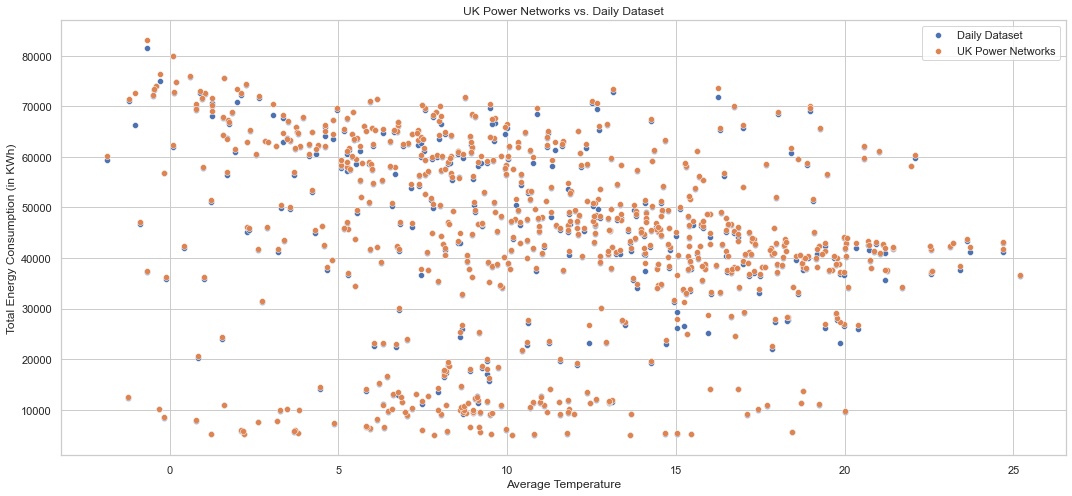

In [16]:
%%time
# Display both data sources on the same plot to identify if there is variation in the data
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,8))
sns.scatterplot(x="Temp_Avg", y="EC_Sum",
                data=df_DailyDataset_ByDate_WithWeather)
sns.scatterplot(x="Temp_Avg", y="EC_Sum",
                data=df_UKPowerNetworks_ByDate_WithWeather).set_title('UK Power Networks vs. Daily Dataset')
plt.xlabel('Average Temperature')
plt.ylabel('Total Energy Consumption (in KWh)')
plt.legend(['Daily Dataset','UK Power Networks'])
plt.grid(True)

Wall time: 84.8 ms


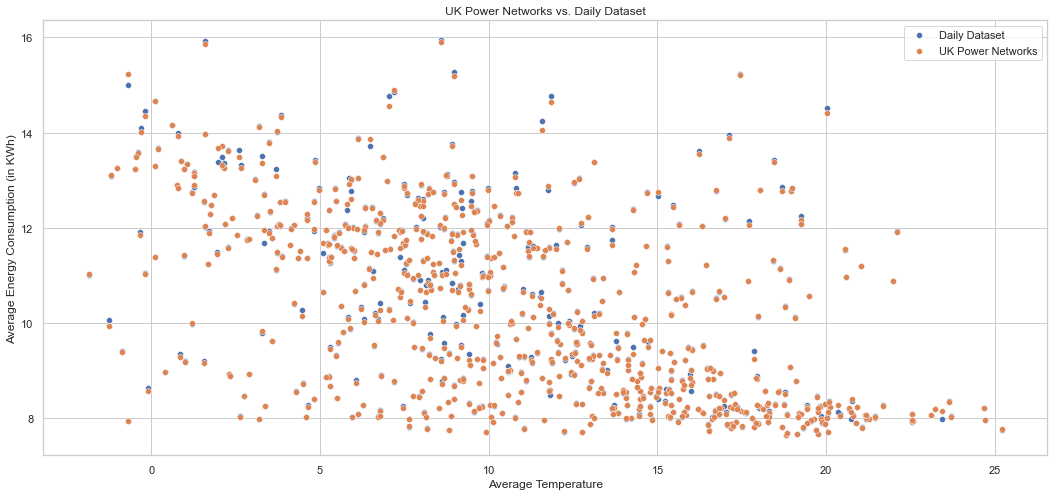

In [17]:
%%time
# Display both data sources on the same plot to identify if there is variation in the data
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,8))
sns.scatterplot(x="Temp_Avg", y="EC_Mean",
                data=df_DailyDataset_ByDate_WithWeather)
sns.scatterplot(x="Temp_Avg", y="EC_Mean",
                data=df_UKPowerNetworks_ByDate_WithWeather).set_title('UK Power Networks vs. Daily Dataset')
plt.xlabel('Average Temperature')
plt.ylabel('Average Energy Consumption (in KWh)')
plt.legend(['Daily Dataset','UK Power Networks'])
plt.grid(True)

Wall time: 175 ms


Text(0.5, 1.0, 'Daily Dataset')

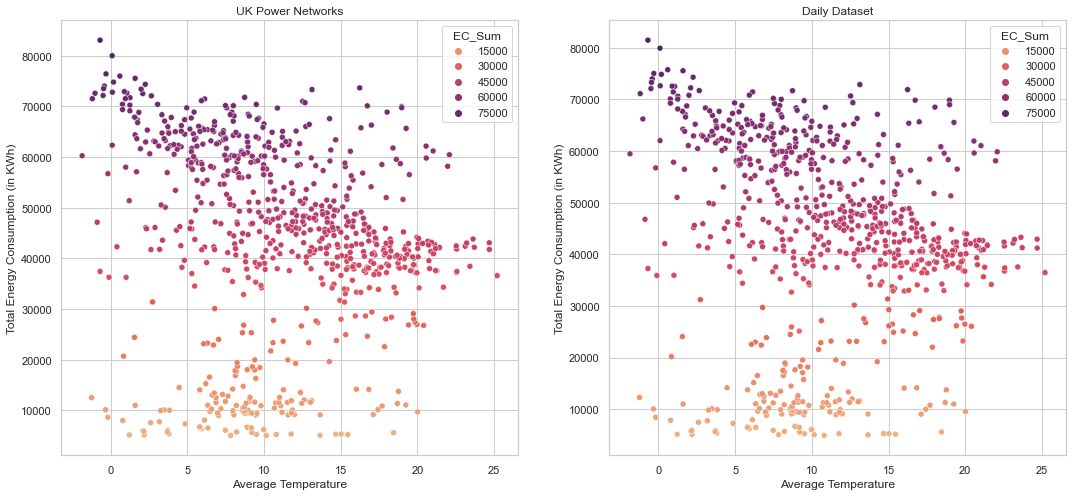

In [18]:
%%time
# Display both data sources on separate (side-by-side) plots to see if they both resemble the same trend
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,8))
for ax in axes:
    ax.set(xlabel='Average Temperature', ylabel='Total Energy Consumption (in KWh)')
    ax.grid(True)
sns.scatterplot(x="Temp_Avg", y="EC_Sum", hue="EC_Sum", palette="flare",
                data=df_UKPowerNetworks_ByDate_WithWeather, ax=axes[0]).set_title('UK Power Networks')
sns.scatterplot(x="Temp_Avg", y="EC_Sum", hue="EC_Sum", palette="flare",
                data=df_DailyDataset_ByDate_WithWeather, ax=axes[1]).set_title('Daily Dataset')

Wall time: 109 ms


Text(0.5, 1.0, 'Daily Dataset')

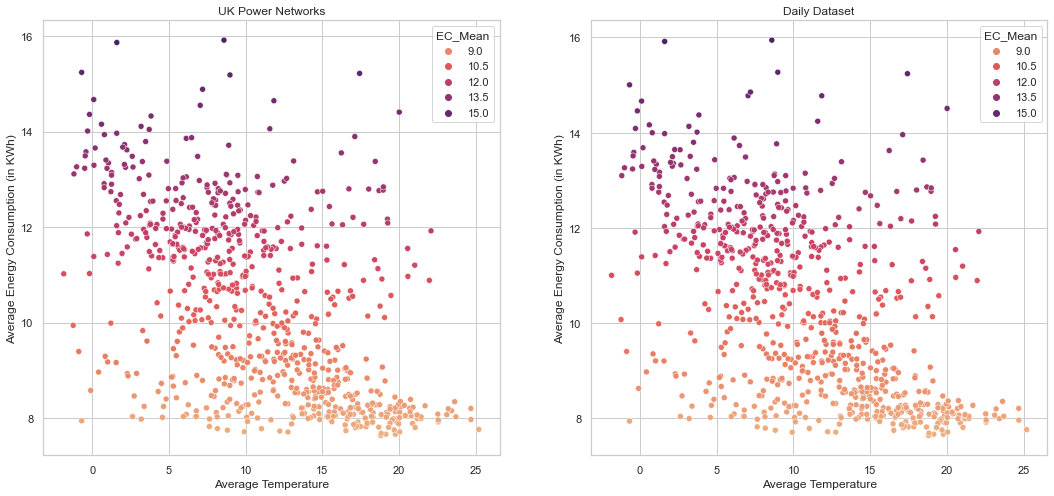

In [38]:
%%time
# Display both data sources on separate (side-by-side) plots to see if they both resemble the same trend
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,8))
for ax in axes:
    ax.set(xlabel='Average Temperature', ylabel='Average Energy Consumption (in KWh)')
    ax.grid(True)
sns.scatterplot(x="Temp_Avg", y="EC_Mean", hue="EC_Mean", palette="flare",
                data=df_UKPowerNetworks_ByDate_WithWeather, ax=axes[0]).set_title('UK Power Networks')

sns.scatterplot(x="Temp_Avg", y="EC_Mean", hue="EC_Mean", palette="flare",
                data=df_DailyDataset_ByDate_WithWeather, ax=axes[1]).set_title('Daily Dataset')
#x = df_DailyDataset_ByDate_WithWeather['Temp_Avg']
#y = df_DailyDataset_ByDate_WithWeather['EC_Mean']
#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)
#plt.plot(x,p(x),"r")

Wall time: 72.9 ms


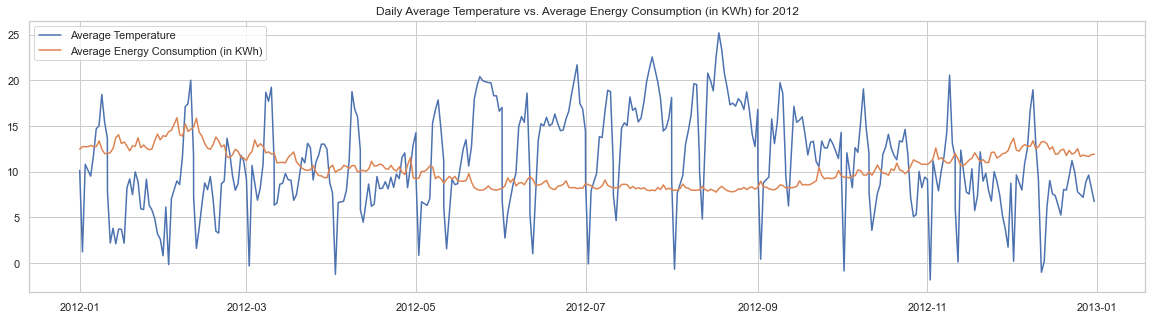

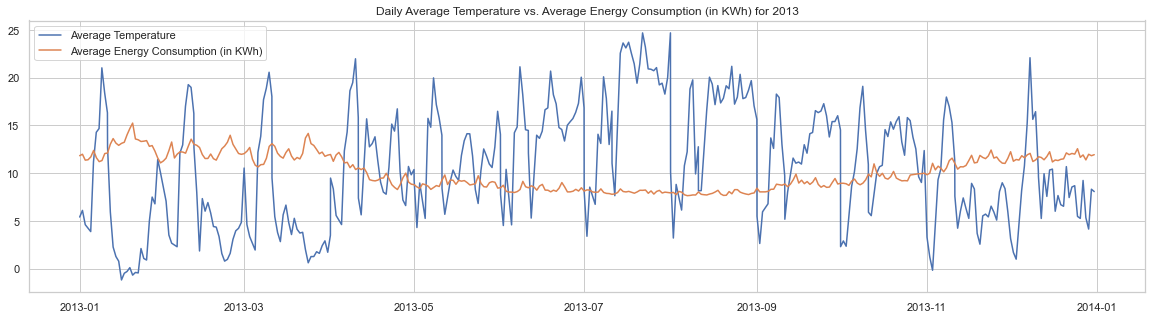

In [42]:
%%time
# Visualize Weather Data for each Year (Everyday) vs Average Energy Consumption
# since we are comparing with weather, we will loop all weather years in the weather dataset
df_Weather_GroupedByYear = df_Weather.groupby(df_Weather['Date'].dt.year)
for SingleGroupedYear in dict(list(df_Weather_GroupedByYear)):
    plt.figure(figsize=(20,5))    
    df_Weather_SingleGroupedYear = df_Weather_GroupedByYear.get_group(SingleGroupedYear)
    df_UKPowerNetworks_ByYear = df_UKPowerNetworks_ByDate_WithWeather[df_UKPowerNetworks_ByDate_WithWeather['DateOnly'].dt.year == SingleGroupedYear]
    plt.plot(df_Weather_SingleGroupedYear['Date'], df_Weather_SingleGroupedYear['Temp_Avg'])
    #plt.figure(figsize=(20,5))    
    plt.plot(df_UKPowerNetworks_ByYear['DateOnly'], (df_UKPowerNetworks_ByYear['EC_Mean']))
    plt.legend(['Average Temperature', 'Average Energy Consumption (in KWh)'], loc=2)
    plt.title('Daily Average Temperature vs. Average Energy Consumption (in KWh) for ' + str(SingleGroupedYear))
    plt.grid(True)

Wall time: 55 ms


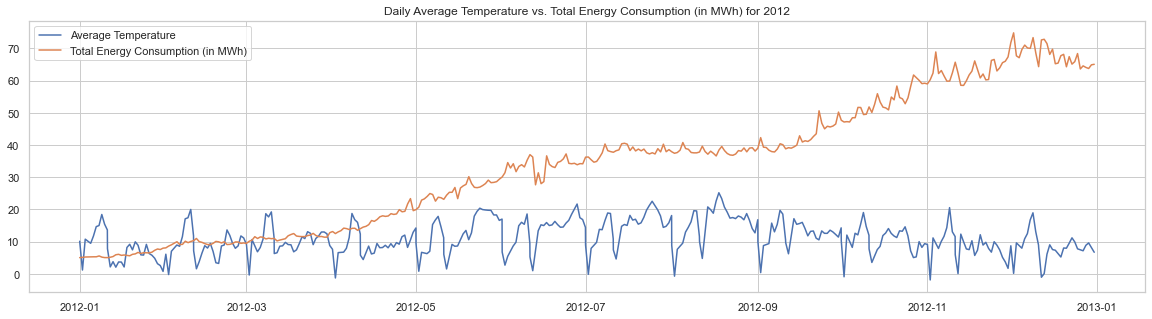

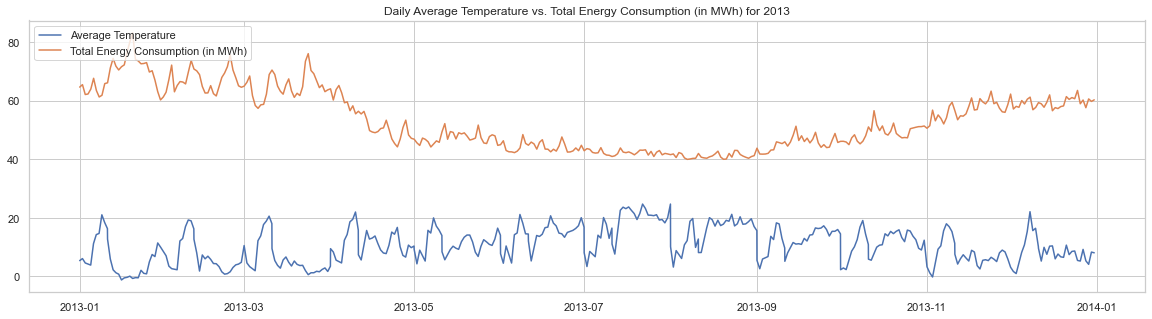

In [20]:
%%time
# Visualize Weather Data for each Year (Everyday) vs Sum Energy Consumption (in mWH) [Scaled]
# since we are comparing with weather, we will loop all weather years in the weather dataset
df_Weather_GroupedByYear = df_Weather.groupby(df_Weather['Date'].dt.year)
for SingleGroupedYear in dict(list(df_Weather_GroupedByYear)):
    plt.figure(figsize=(20,5))    
    df_Weather_SingleGroupedYear = df_Weather_GroupedByYear.get_group(SingleGroupedYear)
    df_UKPowerNetworks_ByYear = df_UKPowerNetworks_ByDate_WithWeather[df_UKPowerNetworks_ByDate_WithWeather['DateOnly'].dt.year == SingleGroupedYear]
    plt.plot(df_Weather_SingleGroupedYear['Date'], df_Weather_SingleGroupedYear['Temp_Avg'])
    #plt.figure(figsize=(20,5))    
    plt.plot(df_UKPowerNetworks_ByYear['DateOnly'], (df_UKPowerNetworks_ByYear['EC_Sum']/1000)) #Scaled to fit with weather data
    plt.legend(['Average Temperature', 'Total Energy Consumption (in MWh)'], loc=2)
    plt.title('Daily Average Temperature vs. Total Energy Consumption (in MWh) for ' + str(SingleGroupedYear))
    plt.grid(True)

#### Additional Plots (Not used in results or conclusion)

In [616]:
%%time
# Visualize Weather Data for each Year (By Month) vs Energy Consumption
'''
df_Weather_GroupedByYear = df_Weather.groupby(df_Weather['Date'].dt.year)
for SingleGroupedYear in dict(list(df_Weather_GroupedByYear)):
    plt.figure(figsize=(20,5))
    df_SingleGroupedYear = df_Weather_GroupedByYear.get_group(SingleGroupedYear)    
    df_SingleGroupedYear_ByMonth = df_SingleGroupedYear.groupby(df_SingleGroupedYear['Date'].dt.month)['Temp_Avg'].mean()
    plt.plot(df_SingleGroupedYear_ByMonth)
    plt.figure(figsize=(20,5))
    df_UKPowerNetworks_ByYear = df_UKPowerNetworks_ByDate_WithWeather[df_UKPowerNetworks_ByDate_WithWeather['DateOnly'].dt.year == SingleGroupedYear]
    df_UKPowerNetworks_ByMonth = df_UKPowerNetworks_ByYear.groupby(df_SingleGroupedYear['Date'].dt.month)['EC_Mean'].mean()
    plt.plot(df_UKPowerNetworks_ByMonth)
    plt.grid(True)
'''
assert True # to ignore output
## Not much to gather from these - but worth exploring

Wall time: 0 ns


---
---
# Task 2:
# Overlay and Explore impact of UK Holiday on energy consumption 

### Steps:
1. Examine UK Holiday Data 
2. Overlay UK Holiday over day-level data - add "day of the week" attribute
3. To obtain energy consumption, group by "day of the week" and "is holiday" and aggregate average temperature for regular days and holiday days

Wall time: 48.8 ms


<AxesSubplot:>

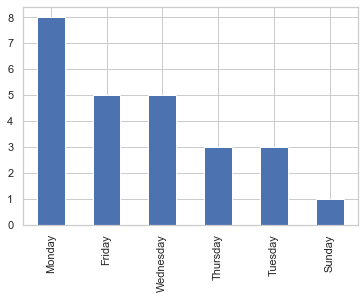

In [48]:
%%time
# We can see that most of the holidays fall on Mondays - which could skew/offset our findings for other days
df_UKHolidays['Date'].dt.day_name().value_counts().plot.bar()

In [49]:
%%time
# Add "Day Of The Week" attribute to all data sources to simplify grouping
df_UKPowerNetworks_ByDate_WithWeather['DayOfWeek'] = df_UKPowerNetworks_ByDate_WithWeather['DateOnly'].dt.day_name()
df_DailyDataset_ByDate_WithWeather['DayOfWeek'] = df_DailyDataset_ByDate_WithWeather['DateOnly'].dt.day_name()

Wall time: 2 ms


In [50]:
%%time
# Add "Is Holiday" attribute to day level data
df_UKPowerNetworks_ByDate_WithWeather['IsHoliday'] = df_UKPowerNetworks_ByDate_WithWeather.DateOnly.isin(df_UKHolidays['Date'])
df_DailyDataset_ByDate_WithWeather['IsHoliday'] = df_DailyDataset_ByDate_WithWeather.DateOnly.isin(df_UKHolidays['Date'])

Wall time: 5.02 ms


Wall time: 68.5 ms


<BarContainer object of 2 artists>

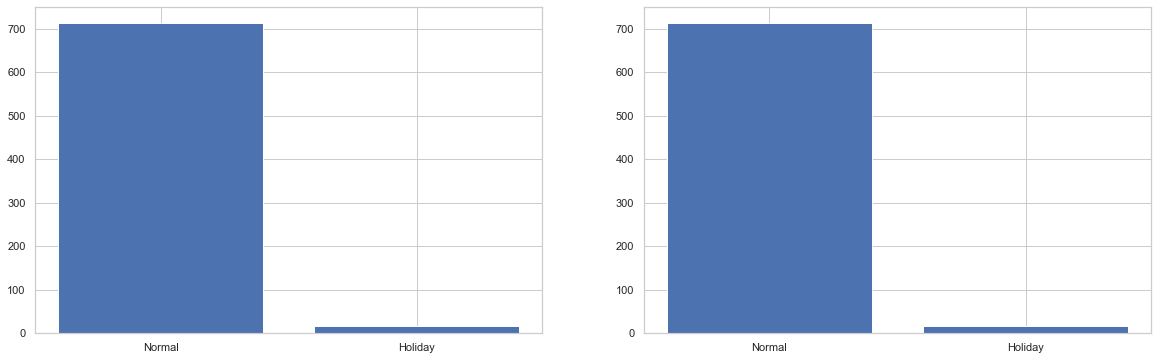

In [51]:
%%time
# Explore how many days from our dataset are actually holidays
plt.figure(figsize=(20,6)) 
plt.subplot(1, 2, 1)
plt.bar(['Normal','Holiday'],df_UKPowerNetworks_ByDate_WithWeather['IsHoliday'].value_counts())
plt.subplot(1, 2, 2)
plt.bar(['Normal','Holiday'],df_DailyDataset_ByDate_WithWeather['IsHoliday'].value_counts())
# We can see that we have very few holidays (17) in our dataset which could skew/offset our findings

In [52]:
%%time
# Calculate Average Energy Consumption by Day of the Week for Holidays and Normal Days separately
## Apply the same on both data sources (UK Power Networks and Daily Dataset)
df_UKPowerNetworks_ByDayOfWeek = pd.merge(left=df_UKPowerNetworks_ByDate_WithWeather[df_UKPowerNetworks_ByDate_WithWeather['IsHoliday']].groupby('DayOfWeek').agg(Avg_Mean_EC_Holiday=('EC_Mean', 'mean'), Avg_Sum_EC_Holiday=('EC_Sum', 'mean')),
                                      right = df_UKPowerNetworks_ByDate_WithWeather[~(df_UKPowerNetworks_ByDate_WithWeather['IsHoliday'])].groupby('DayOfWeek').agg(Avg_Mean_EC_Normal=('EC_Mean', 'mean'), Avg_Sum_EC_Normal=('EC_Sum', 'mean')),
                                      left_on='DayOfWeek',
                                      right_on='DayOfWeek')

df_DailyDataset_ByDayOfWeek = pd.merge(left=df_DailyDataset_ByDate_WithWeather[df_DailyDataset_ByDate_WithWeather['IsHoliday']].groupby('DayOfWeek').agg(Avg_Mean_EC_Holiday=('EC_Mean', 'mean'), Avg_Sum_EC_Holiday=('EC_Sum', 'mean')),
                                      right = df_DailyDataset_ByDate_WithWeather[~(df_DailyDataset_ByDate_WithWeather['IsHoliday'])].groupby('DayOfWeek').agg(Avg_Mean_EC_Normal=('EC_Mean', 'mean'), Avg_Sum_EC_Normal=('EC_Sum', 'mean')),
                                      left_on='DayOfWeek',
                                      right_on='DayOfWeek')

Wall time: 70.3 ms


Wall time: 100 ms


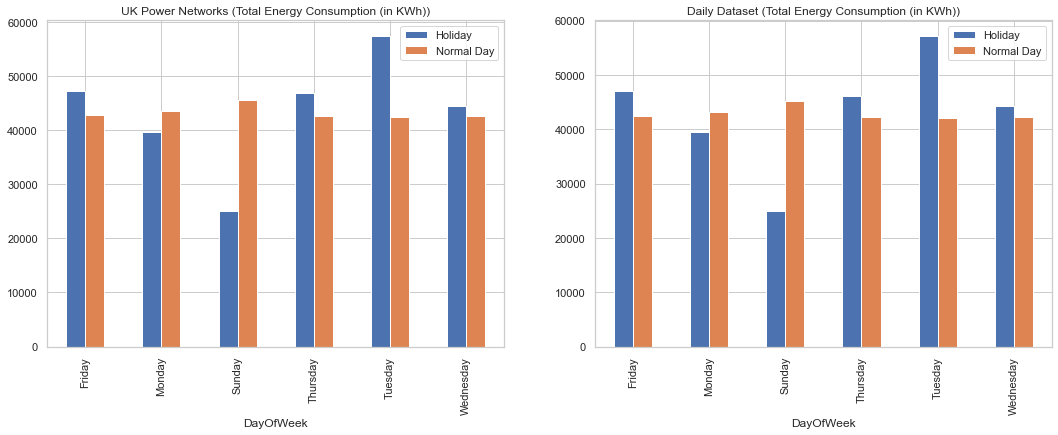

In [53]:
%%time
# Display Average Total Energy Consumption per Week Day (Holiday vs. Normal)
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
for ax in axes:
    ax.grid(True)
df_UKPowerNetworks_ByDayOfWeek[['Avg_Sum_EC_Holiday', 'Avg_Sum_EC_Normal']].plot.bar(title='UK Power Networks (Total Energy Consumption (in KWh))', ax = axes[0])
axes[0].legend(['Holiday', 'Normal Day'])

df_DailyDataset_ByDayOfWeek[['Avg_Sum_EC_Holiday', 'Avg_Sum_EC_Normal']].plot.bar(title='Daily Dataset (Total Energy Consumption (in KWh))', ax = axes[1])
axes[1].legend(['Holiday', 'Normal Day'])

Wall time: 129 ms


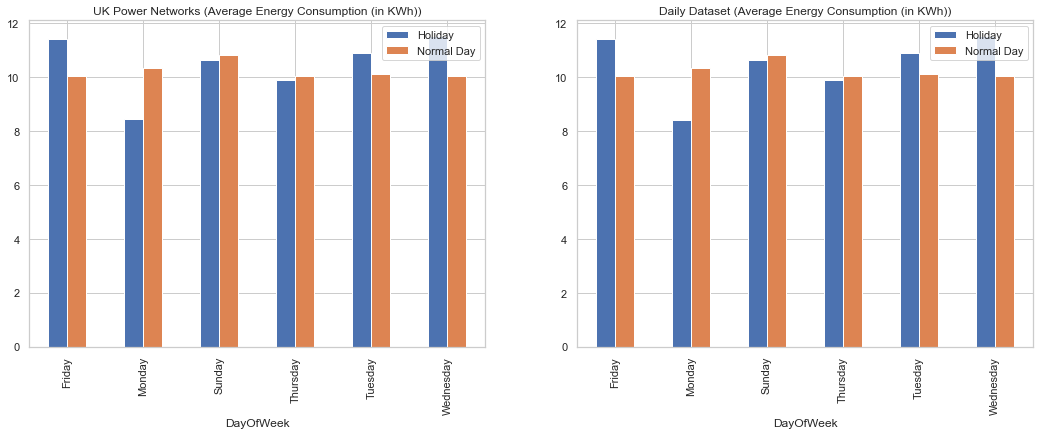

In [54]:
%%time
# Display Average Mean Energy Consumption per Week Day (Holiday vs. Normal)
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
for ax in axes:
    ax.grid(True)
df_UKPowerNetworks_ByDayOfWeek[['Avg_Mean_EC_Holiday', 'Avg_Mean_EC_Normal']].plot.bar(title='UK Power Networks (Average Energy Consumption (in KWh))', ax = axes[0])
axes[0].legend(['Holiday', 'Normal Day'])

df_DailyDataset_ByDayOfWeek[['Avg_Mean_EC_Holiday', 'Avg_Mean_EC_Normal']].plot.bar(title='Daily Dataset (Average Energy Consumption (in KWh))', ax = axes[1])
axes[1].legend(['Holiday', 'Normal Day'])

Wall time: 490 ms


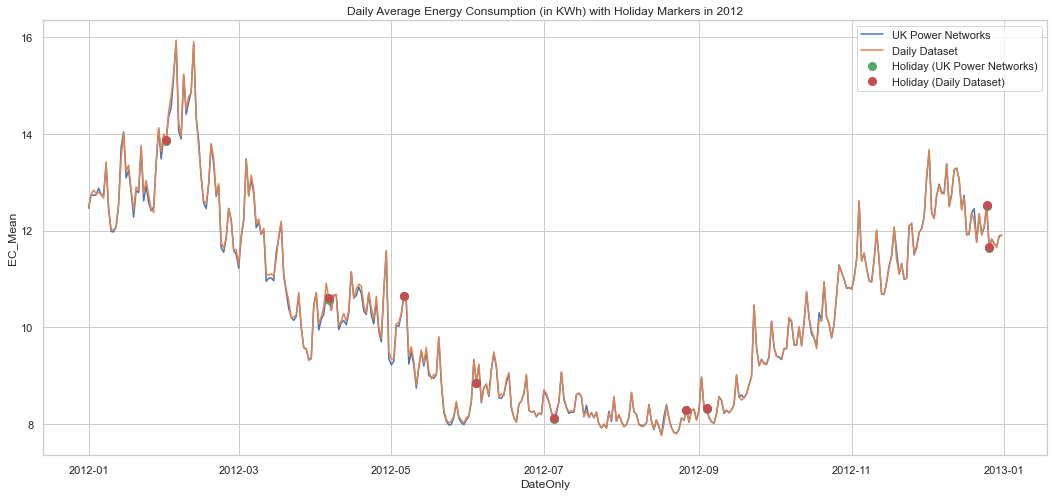

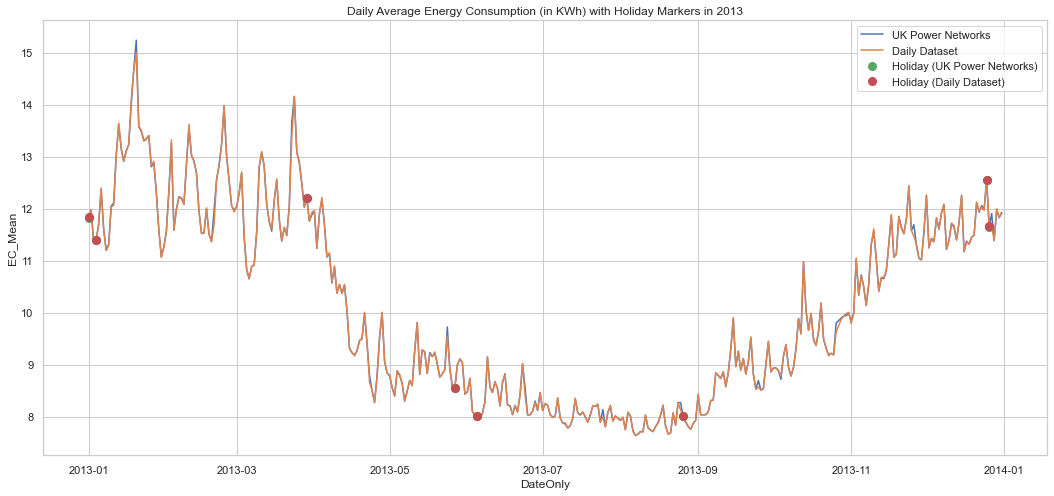

In [56]:
%%time
for SingleGroupedYear in range(StudyTimeFrame_StartYear, StudyTimeFrame_EndYear + 1):
    SingleYear_ToPlot_UKPowerNetworks = df_UKPowerNetworks_ByDate_WithWeather[df_UKPowerNetworks_ByDate_WithWeather.DateOnly.dt.year == SingleGroupedYear]
    SingleYear_ToPlot_DailyDataset = df_DailyDataset_ByDate_WithWeather[df_DailyDataset_ByDate_WithWeather.DateOnly.dt.year == SingleGroupedYear]
    plt.figure(figsize=(18,8))
    
    ## Display Daily Average Temperature -- This is removed because it spreads the graphs and makes it hard to see trend
    #sns.lineplot(x="Date", y="Temp_Avg",
    #             data=df_Weather[df_Weather['Date'].dt.year == SingleGroupedYear])
    
    ## Display Daily Average Readings and Highlight Holidays (UK Power Networks)
    sns.lineplot(x="DateOnly", y="EC_Mean",
                 data=SingleYear_ToPlot_UKPowerNetworks)
    ## Display Daily Average Readings and Highlight Holidays (Daily Dataset)
    sns.lineplot(x="DateOnly", y="EC_Mean",
                 data=SingleYear_ToPlot_DailyDataset)
    ## Highlight UK Power Network Holidays
    plt.plot(SingleYear_ToPlot_UKPowerNetworks[SingleYear_ToPlot_UKPowerNetworks['IsHoliday']]['DateOnly'],
             SingleYear_ToPlot_UKPowerNetworks[SingleYear_ToPlot_UKPowerNetworks['IsHoliday']]['EC_Mean'],
             'go', markersize=8)
    ## Highlight Daily Dataset Holidays
    plt.plot(SingleYear_ToPlot_DailyDataset[SingleYear_ToPlot_DailyDataset['IsHoliday']]['DateOnly'],
             SingleYear_ToPlot_DailyDataset[SingleYear_ToPlot_DailyDataset['IsHoliday']]['EC_Mean'],
             'ro', markersize=8)
    plt.legend(['UK Power Networks', 'Daily Dataset', 'Holiday (UK Power Networks)', 'Holiday (Daily Dataset)'])
    plt.title('Daily Average Energy Consumption (in KWh) with Holiday Markers in ' + str(SingleGroupedYear))

Wall time: 275 ms


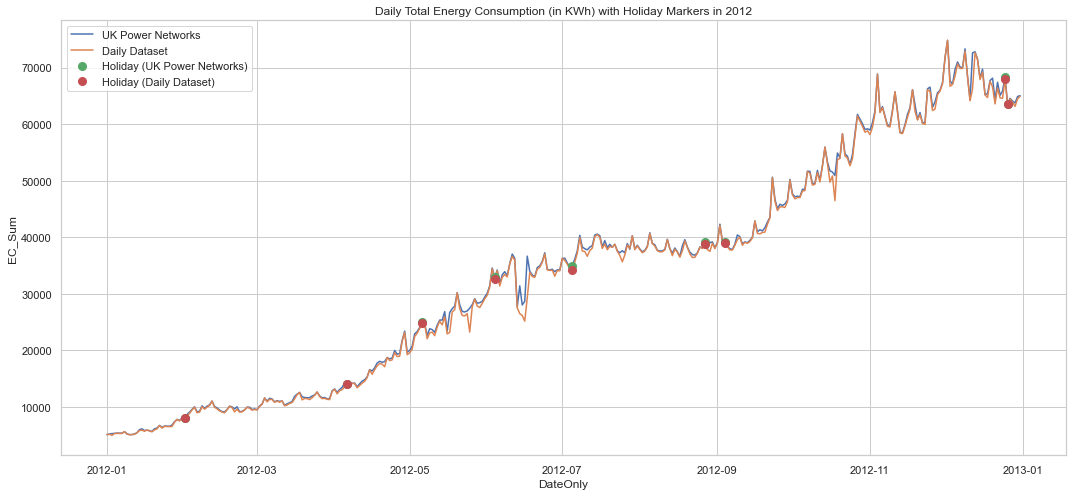

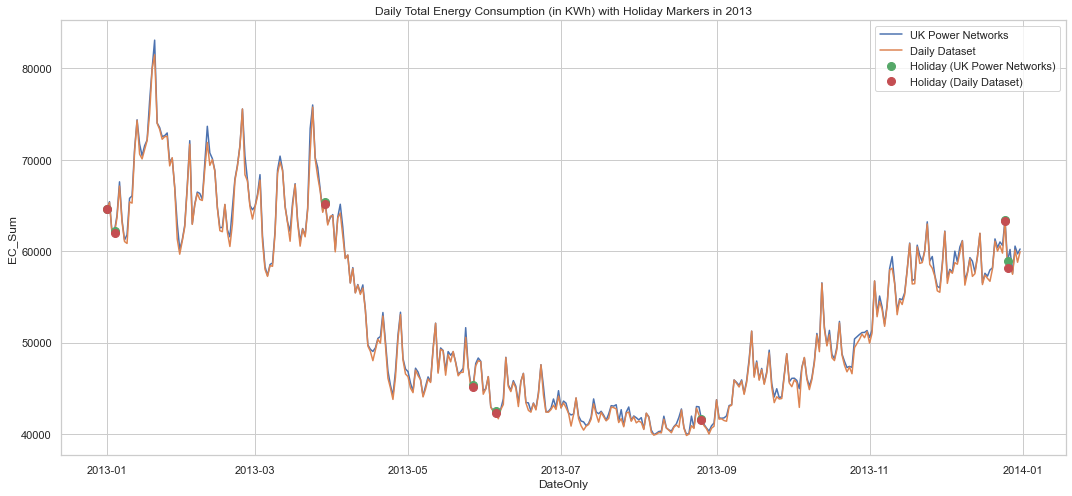

In [51]:
%%time
for SingleGroupedYear in range(StudyTimeFrame_StartYear, StudyTimeFrame_EndYear + 1):
    SingleYear_ToPlot_UKPowerNetworks = df_UKPowerNetworks_ByDate_WithWeather[df_UKPowerNetworks_ByDate_WithWeather.DateOnly.dt.year == SingleGroupedYear]
    SingleYear_ToPlot_DailyDataset = df_DailyDataset_ByDate_WithWeather[df_DailyDataset_ByDate_WithWeather.DateOnly.dt.year == SingleGroupedYear]
    plt.figure(figsize=(18,8))
    ## Display Daily Total Readings and Highlight Holidays (UK Power Networks)
    sns.lineplot(x="DateOnly", y="EC_Sum",
                 data=SingleYear_ToPlot_UKPowerNetworks)
    ## Display Daily Total Readings and Highlight Holidays (Daily Dataset)
    sns.lineplot(x="DateOnly", y="EC_Sum",
                 data=SingleYear_ToPlot_DailyDataset)
    ## Highlight UK Power Network Holidays
    plt.plot(SingleYear_ToPlot_UKPowerNetworks[SingleYear_ToPlot_UKPowerNetworks['IsHoliday']]['DateOnly'],
             SingleYear_ToPlot_UKPowerNetworks[SingleYear_ToPlot_UKPowerNetworks['IsHoliday']]['EC_Sum'],
             'go', markersize=8)
    ## Highlight Daily Dataset Holidays
    plt.plot(SingleYear_ToPlot_DailyDataset[SingleYear_ToPlot_DailyDataset['IsHoliday']]['DateOnly'],
             SingleYear_ToPlot_DailyDataset[SingleYear_ToPlot_DailyDataset['IsHoliday']]['EC_Sum'],
             'ro', markersize=8)
    plt.legend(['UK Power Networks', 'Daily Dataset', 'Holiday (UK Power Networks)', 'Holiday (Daily Dataset)'])
    plt.title('Daily Total Energy Consumption (in KWh) with Holiday Markers in ' + str(SingleGroupedYear))

---
---
# Task 3:
# Explore relationship between ACORN Categories and Energy Consumption 

### Steps:
1. We already obtained daily weather conditions (average temperature) from the above steps
2. To obtain energy consumption, we will use the UK Power Networks data source and sum all energy consumptions for that given date - grouped by ACORN category which is obtained from the each household

### Important note: skip the loading tasks if files are available as loading data may take up to 30 minutes
### <a href='#Task-3:-Visualizations'>Jump to Visualization</a>

### Data Source: UK Power Networks

In [658]:
%%time
# Step 1 - Load All Data from All CSV files
df_UKPowerNetworks_FullSet = ddf.read_csv('dataset/UK_Power_Networks/*.csv',
                                          names=['HouseID', 'tariff', 'Date', 'EC', 'AC_Code', 'AC_Name'],
                                          header=0)

# Step 2 - Select only relevent columns
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[['HouseID', 'Date', 'EC']]

# Step 3 - Filter out excluded Households (that were removed when cleaning data)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet.HouseID.isin(df_Households['ID'])]

# Step 4 - Prepare Households with Index to Merge with valid ACORN Category
df_Households_withIndex = df_Households[['ID','ACORN_Category']].set_index('ID')
df_UKPowerNetworks_FullSet = ddf.merge(left=df_UKPowerNetworks_FullSet,
                                       right=df_Households_withIndex,
                                       left_on='HouseID', right_on='ID')

# Step 5 - Convert 'Date' to DateTime data type
df_UKPowerNetworks_FullSet['Date'] = ddf.to_datetime(df_UKPowerNetworks_FullSet['Date'])

# Step 6 - Adjust Mid-Night Readings to be for the previous date (last 30-minutes of yesterday)
## Declare midnight
midnight = datetime.time(0,0)
## Extract midnight records
df_midNightReadings = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time == midnight]
## Remove midnight records from dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[df_UKPowerNetworks_FullSet['Date'].dt.time != midnight]
## Shift midnight to -1 minute
df_midNightReadings['Date'] = (df_midNightReadings['Date'] - datetime.timedelta(minutes = 1))
## Re-merge updated records with dask dataframe
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.append(df_midNightReadings)

# Step 7 - Filter out excluded dates (Study Time Frame)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet[(StudyTimeFrame_StartYear <= df_UKPowerNetworks_FullSet['Date'].dt.year)
                                                        &
                                                        (df_UKPowerNetworks_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Step 8 - Convert EC readings to numeric (otherwise NaN)
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC, errors='coerce'))

# Step 9 - Filter out invalid energy consumption readings
df_UKPowerNetworks_FullSet = df_UKPowerNetworks_FullSet.dropna(subset=['EC'])

# Step 10 - Create Attributes to hold Sum and Mean and Count
df_UKPowerNetworks_FullSet['EC_Sum'] = df_UKPowerNetworks_FullSet['EC']
df_UKPowerNetworks_FullSet['EC_Mean'] = df_UKPowerNetworks_FullSet['EC']
df_UKPowerNetworks_FullSet['EC_Count'] = df_UKPowerNetworks_FullSet['EC']

# Step 11 - Create Date Only attribute to allow for group-by function
df_UKPowerNetworks_FullSet['DateOnly'] = df_UKPowerNetworks_FullSet['Date'].dt.strftime(datetimeFormat)

# Step 12 - Group By (ACORN and House and Date) to obtain EC Mean
df_UKPowerNetworks_ByDate_ByACORNandHouse = df_UKPowerNetworks_FullSet.groupby(['HouseID', 'ACORN_Category', 'DateOnly']).agg({'EC_Sum': 'sum',
                                                                                                                               'EC_Mean': 'sum', # Sum
                                                                                                                               'EC_Count': 'count'})
## Step 13 - Group By (ACORN and House and Date)
df_UKPowerNetworks_ByDate_ByACORN = df_UKPowerNetworks_ByDate_ByACORNandHouse.groupby(['ACORN_Category', 'DateOnly']).agg({'EC_Sum': 'sum',
                                                                                                                           'EC_Mean': 'mean', # Get Mean from Sum
                                                                                                                           'EC_Count': 'count'})

## Reset index to push multi-key as columns
df_UKPowerNetworks_ByDate_ByACORN.reset_index()

Wall time: 343 ms


,ACORN_Category,DateOnly,EC_Sum,EC_Mean,EC_Count
npartitions=1,,,,,
,object,object,int64,float64,int64
,...,...,...,...,...


In [659]:
%%time
# Step 14 - Output data to CSV to avoid repeating above
df_UKPowerNetworks_ByDate_ByACORN.to_csv('dataset/task3/date_ec_acorn_ukpower.csv', single_file=True)

Wall time: 35min 16s


['C:/Users/ARamadan/Documents/PyProjects/Practice2/dataset/task3/date_ec_acorn_ukpower.csv']

### Data Source: Daily Dataset

In [631]:
%%time
# Step 1 - Load All Data from All CSV files
df_DailyDataset_FullSet = ddf.read_csv('dataset/energy_daily/block_*.csv',
                                       names=['HouseID', 'Date', 'EC_Median', 'EC_Mean', 'EC_Max', 'EC_Count', 'EC_STD', 'EC_Sum', 'EC_Min'],
                                       header=0)

# Step 2 - Select only relevent columns
df_DailyDataset_FullSet = df_DailyDataset_FullSet[['HouseID', 'Date', 'EC_Count', 'EC_Mean', 'EC_Sum']]

# Step 3 - Filter out excluded Households (that were removed when cleaning data)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[df_DailyDataset_FullSet.HouseID.isin(df_Households['ID'])]

# Step 4 - Prepare Households with Index to Merge with valid ACORN Category
df_Households_withIndex = df_Households[['ID','ACORN_Category']].set_index('ID')
df_DailyDataset_FullSet = ddf.merge(left=df_DailyDataset_FullSet,
                                    right=df_Households_withIndex,
                                    left_on='HouseID', right_on='ID')

# Step 5 - Only include records that have 48 readings (30 minutes every day)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[df_DailyDataset_FullSet.EC_Count == 48]

# Step 6 - Convert 'Date' to DateTime data type
df_DailyDataset_FullSet['Date'] = ddf.to_datetime(df_DailyDataset_FullSet['Date'])

# Step 7 - Filter out excluded dates (Study Time Frame)
df_DailyDataset_FullSet = df_DailyDataset_FullSet[(StudyTimeFrame_StartYear <= df_DailyDataset_FullSet['Date'].dt.year)
                                                  &
                                                  (df_DailyDataset_FullSet['Date'].dt.year <= StudyTimeFrame_EndYear)]

# Step 8 - Convert EC readings to numeric (otherwise NaN)
df_DailyDataset_FullSet = df_DailyDataset_FullSet.assign(EC = lambda x: ddf.to_numeric(x.EC_Sum, errors='coerce'))

# Step 9 - Filter out invalid energy consumption readings
df_DailyDataset_FullSet = df_DailyDataset_FullSet.dropna(subset=['EC_Sum'])

# Step 10 - Create Attributes to hold Sum and Mean and Count
df_DailyDataset_FullSet['EC_Sum'] = df_DailyDataset_FullSet['EC_Sum']
df_DailyDataset_FullSet['EC_Mean'] = df_DailyDataset_FullSet['EC_Sum']
df_DailyDataset_FullSet['EC_Count'] = df_DailyDataset_FullSet['EC_Sum']

# Step 11 - Create Date Only attribute to allow for group-by function
df_DailyDataset_FullSet['DateOnly'] = df_DailyDataset_FullSet['Date'].dt.strftime(datetimeFormat)

# Step 12 - Group By (ACORN and Date) to obtain EC Mean
df_DailyDataset_ByDate_ByACORN = df_DailyDataset_FullSet.groupby(['ACORN_Category', 'DateOnly']).agg({'EC_Sum': 'sum',
                                                                                                      'EC_Mean': 'mean', # Sum
                                                                                                      'EC_Count': 'count'})
## Reset index to push multi-key as columns
df_DailyDataset_ByDate_ByACORN.reset_index()

Wall time: 187 ms


,ACORN_Category,DateOnly,EC_Sum,EC_Mean,EC_Count
npartitions=1,,,,,
,object,object,float64,float64,int64
,...,...,...,...,...


In [632]:
%%time
# Step 13 - Output data to CSV to avoid repeating above
df_DailyDataset_ByDate_ByACORN.to_csv('dataset/task3/date_ec_acorn_daily.csv', single_file=True)

Wall time: 29.1 s


['C:/Users/ARamadan/Documents/PyProjects/Practice2/dataset/task3/date_ec_acorn_daily.csv']

## Task 3: Visualizations
## To visualize the relationship between different ACORN Categories and Energy Consumption (over a year)
We will use the line plot using both datasets (UK Power Networks & Daily Dataset)

In [14]:
%%time
# Step 99 - Read both data sources from file
df_UKPowerNetworks_ByDate_ByAcorn = pd.read_csv('dataset/task3/date_ec_acorn_ukpower.csv')
df_UKPowerNetworks_ByDate_ByAcorn['DateOnly'] = pd.to_datetime(df_UKPowerNetworks_ByDate_ByAcorn['DateOnly'])

df_DailyDataset_ByDate_ByAcorn = pd.read_csv('dataset/task3/date_ec_acorn_daily.csv')
df_DailyDataset_ByDate_ByAcorn['DateOnly'] = pd.to_datetime(df_DailyDataset_ByDate_ByAcorn['DateOnly'])

Wall time: 39.3 ms


Wall time: 380 ms


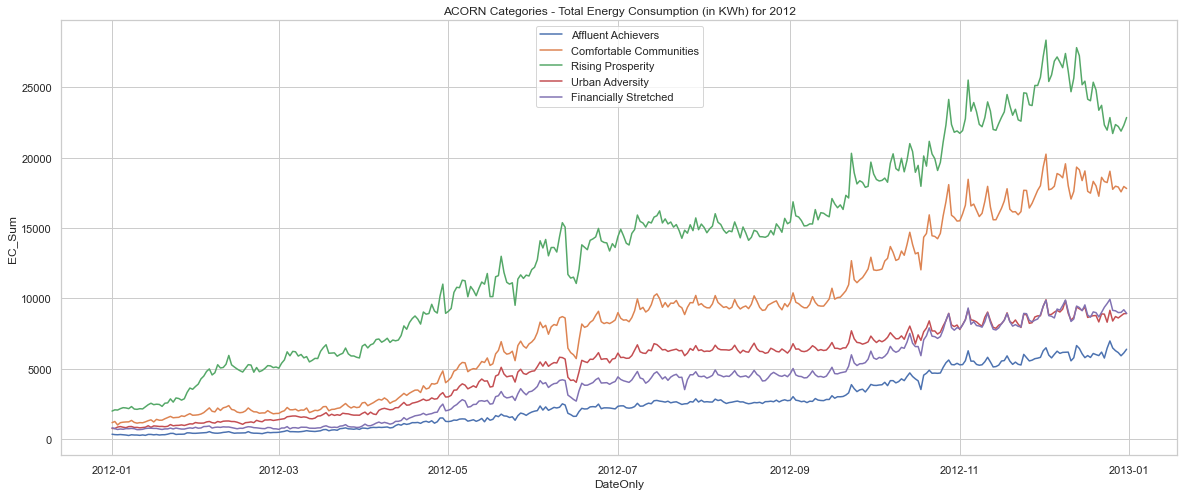

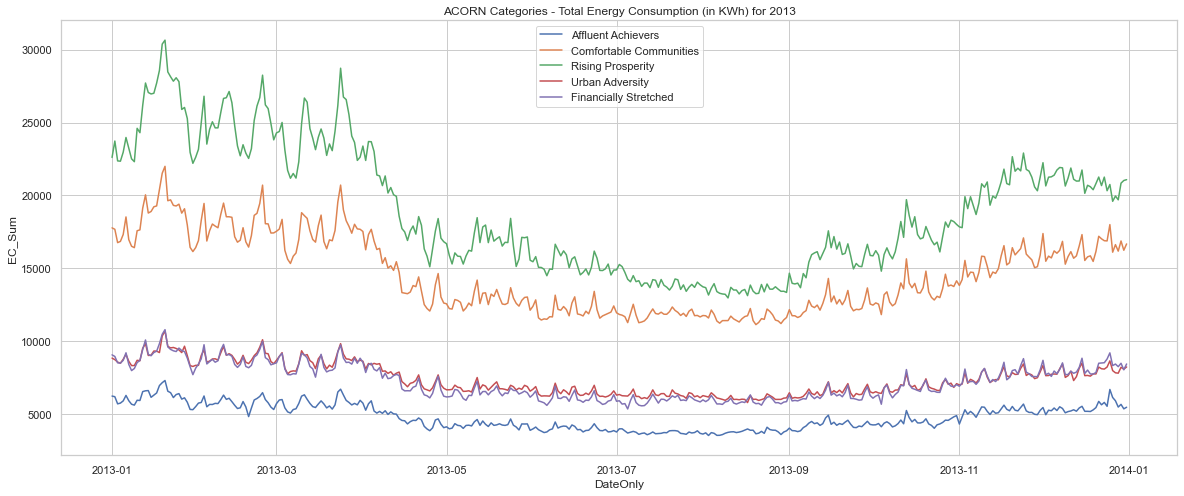

In [73]:
%%time
# Visualize Line Graph for each Year (Daily) vs Total Energy Consumption
# since we are not considering weather data here, we will loop through study timeframe years
for SingleGroupedYear in range(StudyTimeFrame_StartYear, StudyTimeFrame_EndYear + 1):
    plt.figure(figsize=(20,8))
    df_DailyDataset_ByDate_ByAcorn_ByYear = df_DailyDataset_ByDate_ByAcorn[df_DailyDataset_ByDate_ByAcorn.DateOnly.dt.year == SingleGroupedYear]
    sns.lineplot(x='DateOnly', y='EC_Sum', hue='ACORN_Category', data=df_DailyDataset_ByDate_ByAcorn_ByYear)
    plt.legend(loc=9)
    plt.title('ACORN Categories - Total Energy Consumption (in KWh) for ' + str(SingleGroupedYear))
    plt.grid(True)

Wall time: 525 ms


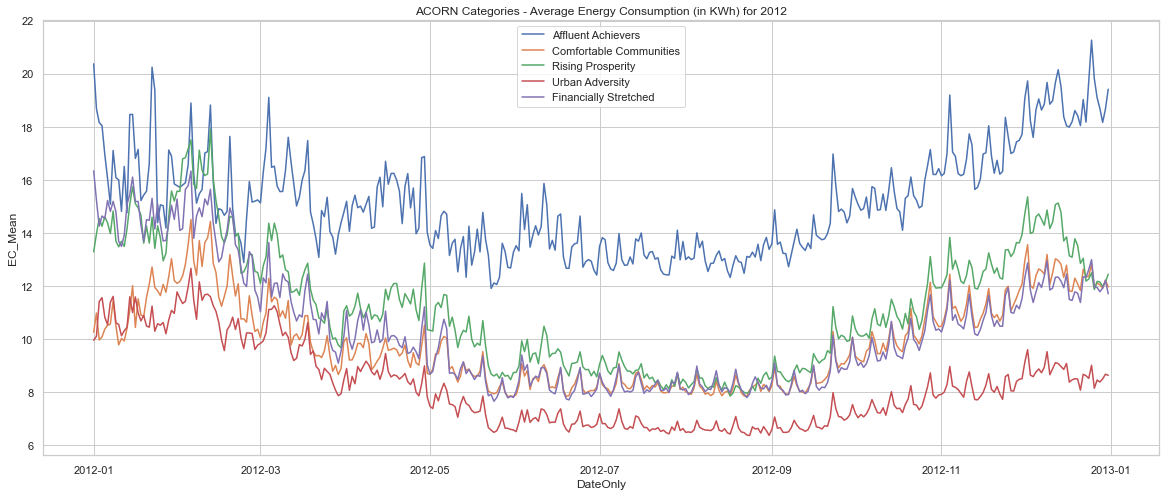

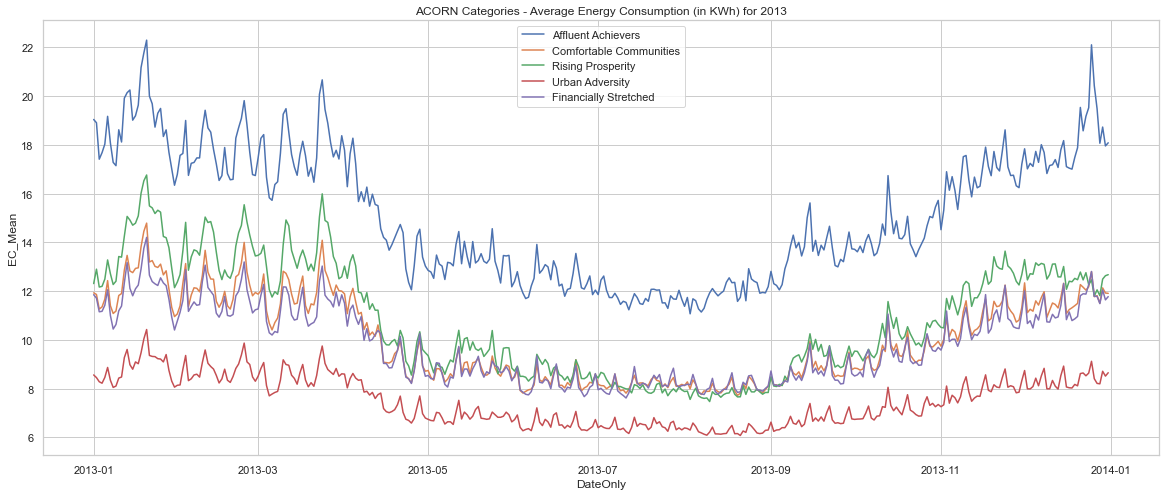

In [74]:
%%time
# Visualize Line Graph for each Year (Daily) vs Average Energy Consumption (in KWh)
# since we are not considering weather data here, we will loop through study timeframe years
for SingleGroupedYear in range(StudyTimeFrame_StartYear, StudyTimeFrame_EndYear + 1):   
    plt.figure(figsize=(20,8))
    df_DailyDataset_ByDate_ByAcorn_ByYear = df_DailyDataset_ByDate_ByAcorn[df_DailyDataset_ByDate_ByAcorn.DateOnly.dt.year == SingleGroupedYear]
    sns.lineplot(x='DateOnly', y='EC_Mean', hue='ACORN_Category', data=df_DailyDataset_ByDate_ByAcorn_ByYear)
    plt.legend(loc=9)
    plt.title('ACORN Categories - Average Energy Consumption (in KWh) for ' + str(SingleGroupedYear))
    plt.grid(True)

# Acknowledgment
A major thanks to the creators of Dask for making this notebook possible with  the limited infrastructure available.
A major thanks to Dr. Hesham for support and guidance in this assignment.